In [3]:
import importlib
import sys
import pandas as pd
from helper import (normalize,
                    time_series_dataset,
                    time_series_dataset_split,
                    time_series_train_test_split,
                    time_series_train_test_split_multiple,
                    create_seq_fast_multiple as create_seq_multiple,
                    train_model)
import matplotlib.pyplot as plt
import torch

WINDOW_SIZE = 10

In [ ]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Current device index:", torch.cuda.current_device())
else:
    print("No GPU detected.")

PyTorch version: 2.5.1
CUDA available: True
Number of GPUs: 1
GPU name: NVIDIA A100-SXM4-40GB
Current device index: 0


In [30]:
name = 'Dataset_Blazer.csv'
#name = 'Dataset_Pacifica.csv'
#name = 'Dataset_QX50_trip-clean.csv'


trips_ice = pd.read_csv(f'../data/{name}', low_memory=False)

# Columns selected for CO2 prediction
selected_columns = [
    'Trip',
    'Velocity[km/h]',
    'Throttle[%]',
    'Motor Torque[Nm]',
    'CO2 Emissions'
]
 
if name == 'Dataset_Blazer.csv' or name == 'Dataset_Pacifica.csv':    
  trips_ice.rename(columns={'Throttle[%]': 'Throttle [%]',
                            'Motor Torque[Nm]': 'Motor Torque [Nm]',
                            'Velocity[km/h]':'Velocity [km/h]',
                            'Ambient Temperature[°C]':'Ambient Temperature [°C]',
                            'Cabin Temperature Sensor[°C]':'Cabin Temperature Sensor [°C]',
                            'Longitudinal Acceleration[m/s^2]':'Longitudinal Acceleration [m/s^2]',
                              }, inplace=True)  

  if name == 'Dataset_Blazer.csv': 
    unique_trips = trips_ice['Trip'].unique()
    noisy_trips = [unique_trips[0], unique_trips[8]]
    trips_ice = trips_ice[~trips_ice['Trip'].isin(noisy_trips)]

if  name == 'Dataset_QX50_trip-clean.csv':
  trips_ice.rename(columns={'Throttle[%]': 'Throttle [%]',
                            'Motor Torque[Nm]': 'Motor Torque [Nm]',
                            'Velocity[km/h]':'Velocity [km/h]',
                            'CO2 Emissions[g/s]': 'CO2 Emissions',
                            'Ambient Temperature[°C]':'Ambient Temperature [°C]',
                            'Cabin Temperature Sensor[°C]':'Cabin Temperature Sensor [°C]',
                            'Longitudinal Acceleration[m/s^2]':'Longitudinal Acceleration [m/s^2]',
                              }, inplace=True)  


#trips_ice = trips_ice[selected_columns]
#for col in trips_ice.columns:
#    if trips_ice[col].dtype == 'object':
#        trips_ice[col] = trips_ice[col].str.replace(',', '.').astype(float)

# Group by Trip and compute the percentage of rows with zero CO2
#trip_zero_ratio = (trips_ice['CO2 Emissions'] == 0).groupby(trips_ice['Trip']).mean()

# Keep only trips with <= 50% zero CO2
#valid_trips = trip_zero_ratio[trip_zero_ratio <= 0.5].index

# Filter the dataframe to only include valid trips
#trips_ice = trips_ice[trips_ice['Trip'].isin(valid_trips)].reset_index(drop=True)




In [19]:
trips_ice['Trip'].unique()

array(['62001024', '62001025', '62001026', '62001027', '62001028',
       '62001031', '62001032 Analysis', '62001033', '62001034',
       '62001035', '62001036', '62001037', '62001038', '62001039',
       '62001040', '62001041', '62001042', '62001043', '62001044'],
      dtype=object)

In [36]:
trips_ice.columns

Index(['Time[s]', 'Velocity [km/h]', 'Throttle [%]', 'Motor Torque [Nm]',
       'CO2 Emissions', 'Ambient Temperature [°C]',
       'Cabin Temperature Sensor [°C]', 'Heat Exchanger Temperature[°C]',
       'Longitudinal Acceleration [m/s^2]', 'Trip'],
      dtype='object')

In [32]:
trips_ice_scaled, trips_ice_X_scaler = normalize(trips_ice, ['Velocity [km/h]', 'Throttle [%]', 'Motor Torque [Nm]'], 'CO2 Emissions')
trips_ice_scaled

,Velocity [km/h],Throttle [%],Motor Torque [Nm],Trip,CO2 Emissions
22749,1.918009e-06,0.350684,0.107150,61908016.0,2.131352
22750,6.496242e-07,0.334931,0.409776,61908016.0,3.261644
22751,3.450147e-07,0.312511,0.293562,61908016.0,4.891567
22752,3.450147e-07,0.304522,0.182477,61908016.0,2.738628
22753,3.450147e-07,0.296416,0.086461,61908016.0,3.417050
...,...,...,...,...,...
98825,9.616250e-04,0.053136,0.036727,61908022.0,0.253294
98826,2.124080e-03,0.053170,0.038861,61908022.0,0.286036
98827,1.396259e-03,0.053333,0.041961,61908022.0,0.230697
98828,2.487690e-04,0.052992,0.036659,61908022.0,0.263753


In [33]:
importlib.reload(sys.modules['helper'])
from helper import time_series_dataset_split

ice_x_train_seq, ice_y_train_seq, ice_x_test_seq, ice_y_test_seq  = time_series_dataset_split(trips_ice_scaled,['CO2 Emissions'], 'Trip', WINDOW_SIZE=WINDOW_SIZE)

print(f"\ntrips_ice_X_train: {ice_x_train_seq.shape}")
print(f"\ntrips_ice_y_train: {ice_y_train_seq.shape}")

print(f"\ntrips_ice_X_test: {len(ice_x_test_seq)}")
print(f"\ntrips_ice_Y_test: {len(ice_y_test_seq)}")

# ice_x_test[0] -> 36309 (sum)




trips_ice_X_train: torch.Size([49462, 10, 3])

trips_ice_y_train: torch.Size([49462, 1])

trips_ice_X_test: 2

trips_ice_Y_test: 2


Model config:MultipleLayerLSTM(
  (input_layer): LSTM(3, 64, batch_first=True)
  (lstm_blocks): ModuleList(
    (0-1): 2 x LSTM_Block(
      (lstm): LSTM(64, 64, batch_first=True)
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (bottleneck): Linear(in_features=64, out_features=32, bias=True)
  (tanh): Tanh()
  (act): GELU(approximate='none')
  (norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)

Epoch 1/50
Train Loss: 1.173193, Val Loss: 0.713253, LR: 0.000190

Epoch 2/50
Train Loss: 0.557444, Val Loss: 0.419247, LR: 0.000280

Epoch 3/50
Train Loss: 0.404871, Val Loss: 0.392450, LR: 0.000370

Epoch 4/50
Train Loss: 0.357314, Val Loss: 0.304257, LR: 0.000460

Epoch 5/50
Train Loss: 0.334496, Val Loss: 0.326614, LR: 0.000550

Epoch 6/50
Train Loss: 0.289130, Val Loss: 0.303868, L

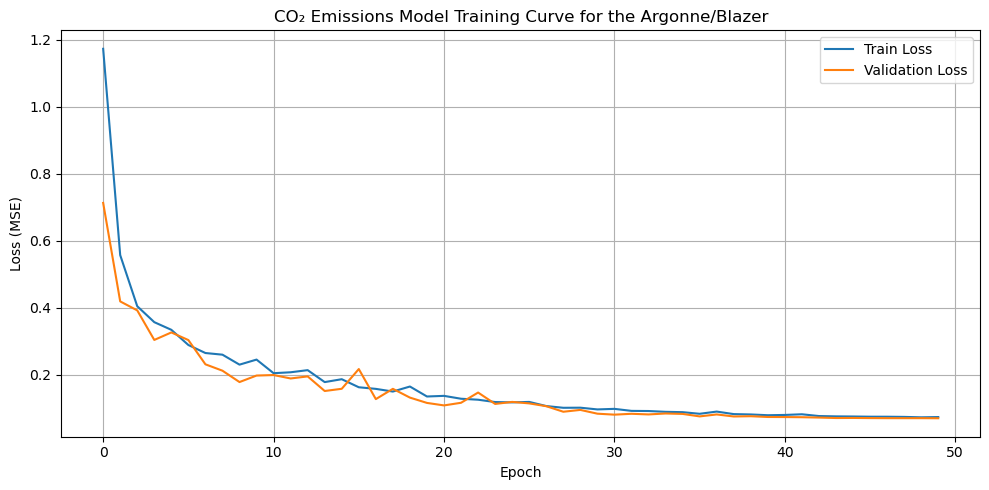


Final MAE: 0.15435976, Final MSE: 0.07052294
Max memory allocated: 0.07 GB


In [34]:
ice_model = train_model(ice_x_train_seq,
                        ice_y_train_seq,title='CO₂ Emissions Model Training Curve for the Argonne/Blazer',
                        num_blocks=2, hidden_dim=64,   max_lr=1.0e-3, base_lr=1e-4, final_lr=2.5e-5, 
                        train_size=0.8, warmup_epochs=10, epochs=50, batch_size=256)

In [20]:
ice_x_test_seq[1].shape

torch.Size([1, 50, 3])

In [38]:
len(ice_x_test_seq)

2

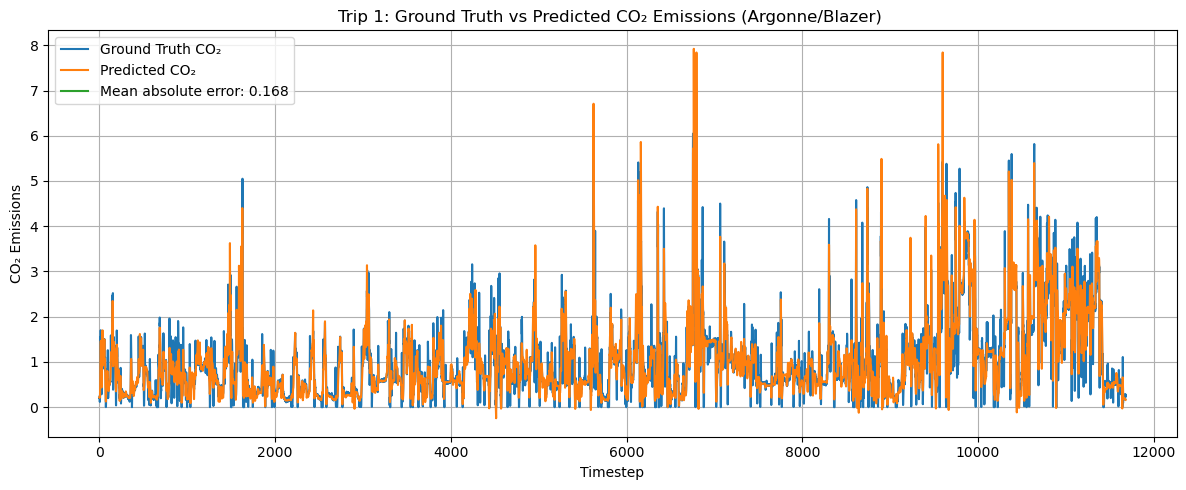

In [37]:
trip_num = 1
trip_test_x, trip_test_y = ice_x_test_seq[trip_num], ice_y_test_seq[trip_num]

t = trip_test_x.size(0)

#sequences = []
prediction_list = []
for i in range(len(trip_test_x)):
    sequence = trip_test_x[i]
    x = sequence.unsqueeze(0).to('cuda') # add batch dim
    with torch.inference_mode():
        pred = ice_model(x).squeeze(0)
        prediction_list.append(pred)

predicted = torch.stack(prediction_list).cpu()  # shape: (T - WINDOW_SIZE, output_size)
true = trip_test_y.cpu()             # match prediction window


difference = predicted - true
mae = torch.mean(abs(difference))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(true, label='Ground Truth CO₂')
plt.plot(predicted, label='Predicted CO₂')
plt.plot(0, label=f'Mean absolute error: %.3f' % mae)
plt.xlabel('Timestep')
plt.ylabel('CO₂ Emissions')
plt.title(f'Trip {trip_num}: Ground Truth vs Predicted CO₂ Emissions (Argonne/Blazer) ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predição de torque e throttle

In [ ]:
trips_ice_scaled, trips_ice_X_scaler

In [27]:
selected_columns = [
    'Velocity [km/h]', 
    'Ambient Temperature [°C]', 
    'Cabin Temperature Sensor [°C]',
    'Longitudinal Acceleration [m/s^2]',
    'Motor Torque [Nm]',
    'Throttle [%]',
    'Trip'
]

selected_trips_ice = trips_ice[selected_columns]


# Normalização
trips_ice_scaled, trips_ice_X_scaler = normalize(
    selected_trips_ice, 
    [
        'Velocity [km/h]', 
        'Ambient Temperature [°C]', 
        'Cabin Temperature Sensor [°C]',
        'Longitudinal Acceleration [m/s^2]'
    ], 
    ['Motor Torque [Nm]', 'Throttle [%]']
)
selected_trips_ice.head()

,Velocity [km/h],Ambient Temperature [°C],Cabin Temperature Sensor [°C],Longitudinal Acceleration [m/s^2],Motor Torque [Nm],Throttle [%],Trip
0,0.001609,22.088,24.934,0.0,24.000,0.0,61907041
1,0.001609,22.088,24.932,0.0,24.000,0.0,61907041
2,0.001609,22.090,24.928,0.0,23.303,0.0,61907041
3,0.001609,22.091,24.927,0.0,23.000,0.0,61907041
4,0.001609,22.091,24.922,0.0,23.000,0.0,61907041


In [32]:
trips_ice_x_train_seq, trips_ice_y_train_seq, trips_ice_x_test, trips_ice_y_test = time_series_dataset_split(selected_trips_ice, ['Motor Torque [Nm]', 'Throttle [%]'], 'Trip', WINDOW_SIZE=WINDOW_SIZE)

print(f"trips_ev_X_train_seq {trips_ice_x_train_seq.shape}")
print(f"trips_ev_y_train_seq {trips_ice_y_train_seq.shape}")
print("\nTEST:")
print(f"trips_ev_X_test_seq {len(trips_ice_x_test)}")
print(f"trips_ev_y_test_seq {len(trips_ice_y_test)}")


trips_ev_X_train_seq torch.Size([302513, 50, 4])
trips_ev_y_train_seq torch.Size([302513, 2])

TEST:
trips_ev_X_test_seq 7
trips_ev_y_test_seq 7


Model config:MultipleLayerLSTM(
  (input_layer): LSTM(4, 256, batch_first=True)
  (lstm_blocks): ModuleList(
    (0-22): 23 x LSTM_Block(
      (lstm): LSTM(256, 256, batch_first=True)
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (bottleneck): Linear(in_features=256, out_features=32, bias=True)
  (tanh): Tanh()
  (act): GELU(approximate='none')
  (norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)

Epoch 1/50
Train Loss: 863.083696, Val Loss: 572.032087, LR: 0.000160

Epoch 2/50
Train Loss: 477.312637, Val Loss: 343.939976, LR: 0.000220

Epoch 3/50
Train Loss: 319.201132, Val Loss: 228.253271, LR: 0.000280

Epoch 4/50
Train Loss: 241.093112, Val Loss: 200.016223, LR: 0.000340

Epoch 5/50
Train Loss: 196.478833, Val Loss: 220.713487, LR: 0.000400

Epoch 6/50
Train Loss: 1

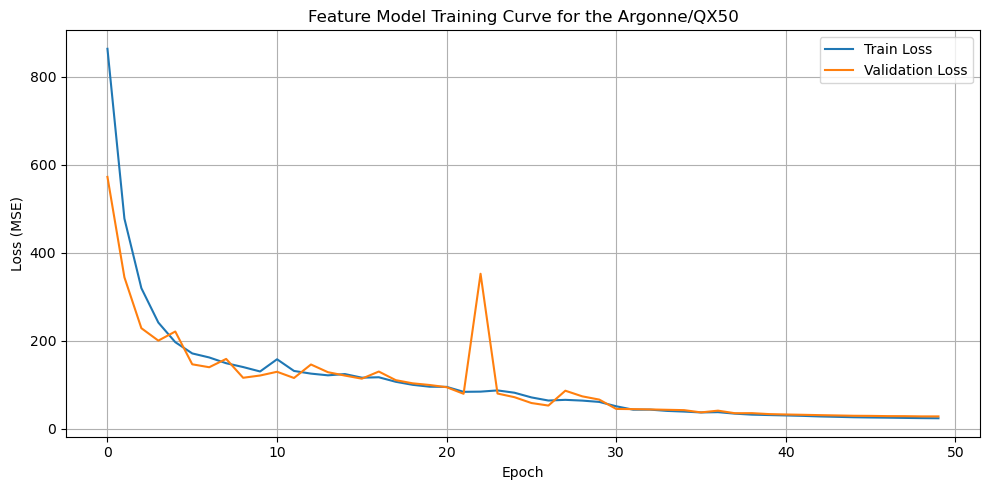


Final MAE: 2.73914290, Final MSE: 27.82160129
Max memory allocated: 35.43 GB


In [33]:
to_th_model = train_model(trips_ice_x_train_seq, 
                          trips_ice_y_train_seq,
                          num_blocks=23,
                          hidden_dim=256,
                          title='Feature Model Training Curve for the Argonne/QX50',
                          base_lr=1.0e-4, max_lr=1.0e-3, final_lr=5e-5,
                          train_size=0.8, warmup_epochs=15, epochs=50,
                          batch_size=2048)

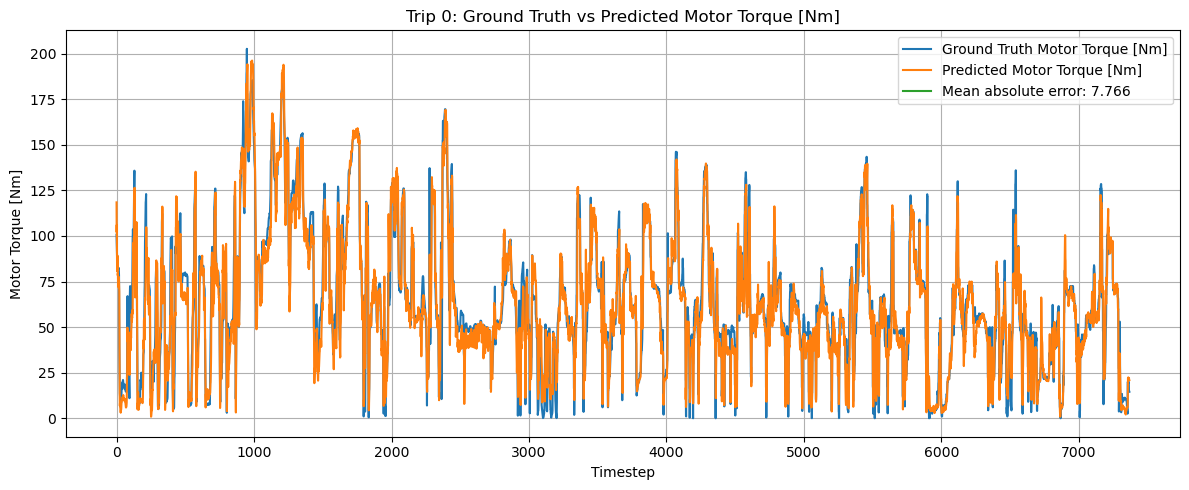

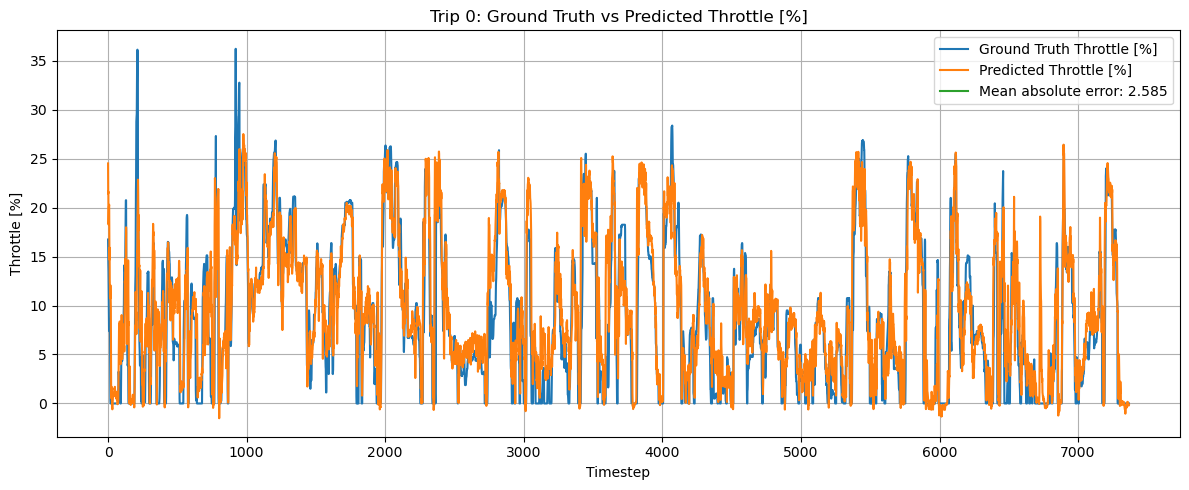

In [34]:
trip_num = 0

trip_test_x, trip_test_y = trips_ice_x_test[trip_num], trips_ice_y_test[trip_num]

# Predict using the model
prediction_list = []
for i in range(len(trip_test_x)):
    sequence = trip_test_x[i].unsqueeze(0).to('cuda')  # Add batch dimension
    with torch.inference_mode():
        pred = to_th_model(sequence).squeeze(0)  # Shape: (2,)
        prediction_list.append(pred)

predicted = torch.stack(prediction_list).cpu()  # Shape: (T - WINDOW_SIZE, 2)
true = trip_test_y.cpu()  # Shape: (T - WINDOW_SIZE, 2)

# Names for each output
output_labels = ['Motor Torque [Nm]', 'Throttle [%]']

# Plot each output
for i in range(predicted.shape[1]):
    plt.figure(figsize=(12, 5))
    plt.plot(true[:, i], label=f'Ground Truth {output_labels[i]}')
    plt.plot(predicted[:, i], label=f'Predicted {output_labels[i]}')
    difference = predicted[:, i] - true[:, i]
    mae = torch.mean(abs(difference))
    plt.plot(0, label=f'Mean absolute error: %.3f' % mae)
    plt.xlabel('Timestep')
    plt.ylabel(output_labels[i])
    plt.title(f'Trip {trip_num}: Ground Truth vs Predicted {output_labels[i]}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# "Proxy" Validation


In [12]:
selected_columns = [
    'Velocity [km/h]', 
    'Ambient Temperature [°C]', 
    'Cabin Temperature Sensor [°C]',
    'Longitudinal Acceleration [m/s^2]',
    'Motor Torque [Nm]',
    'Throttle [%]',
    'Trip'
]

sel_trips_ice = trips_ice[selected_columns]


# Normalização
trips_ice_scaled, trips_ice_X_scaler_1 = normalize(
    sel_trips_ice, 
    [
        'Velocity [km/h]', 
        'Ambient Temperature [°C]', 
        'Cabin Temperature Sensor [°C]',
        'Longitudinal Acceleration [m/s^2]'
    ], 
    ['Motor Torque [Nm]', 'Throttle [%]']
)
ice_x_train_seq_1, ice_y_train_seq_1, ice_x_test_1, ice_y_test_1 = time_series_dataset_split(trips_ice_scaled, ['Motor Torque [Nm]', 'Throttle [%]'], 'Trip', WINDOW_SIZE=WINDOW_SIZE)



In [13]:
selected_columns = [
    'Trip',
    'Time[s]',
    'Velocity [km/h]',
    'Throttle [%]',
    'Motor Torque [Nm]',
    'Ambient Temperature [°C]',
    'Cabin Temperature Sensor [°C]',
    'Longitudinal Acceleration [m/s^2]',
    'CO2 Emissions'
]
sel_trips_ice = trips_ice[selected_columns]

trips_ice_scaled, trips_ice_X_scaler_2 = normalize(
    sel_trips_ice,
    [
        'Velocity [km/h]',
        'Throttle [%]',
        'Motor Torque [Nm]'
    ],
    'CO2 Emissions'
)

ev_x_train_seq_2, ev_y_train_seq_2, ev_x_test_2, ev_y_test_2  = time_series_dataset_split(trips_ice_scaled, ['CO2 Emissions'], 'Trip', WINDOW_SIZE=WINDOW_SIZE)

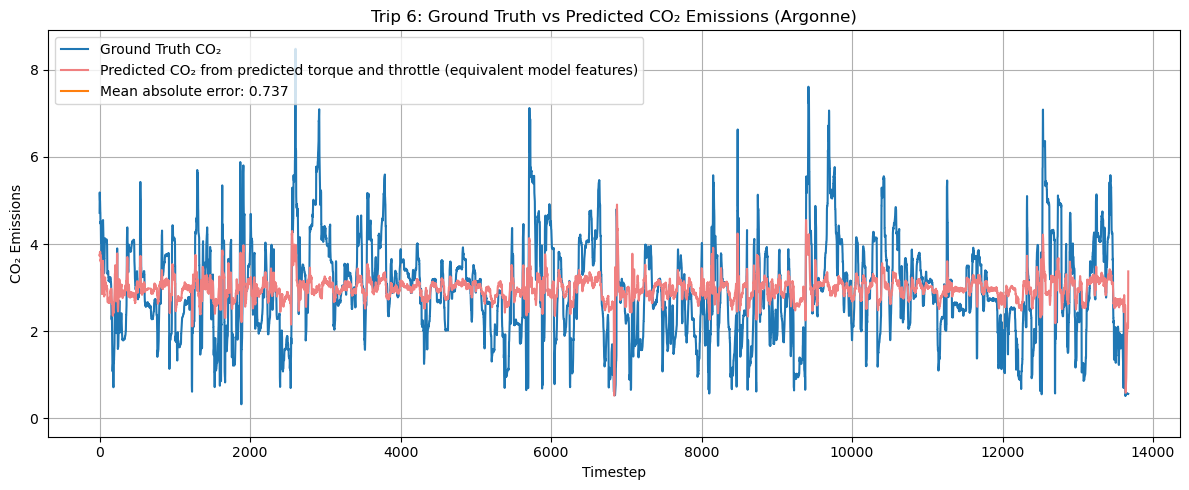

In [24]:
trip_num = 6

trip_test_x, trip_test_y = ice_x_test_1[trip_num], ice_y_test_1[trip_num] # (Vel, ambient_temp, cabin_temp, long_acceleration)

# Predict using the model
prediction_list = []
for i in range(len(trip_test_x)):
    sequence = trip_test_x[i]
    x = sequence.unsqueeze(0).to('cuda') # add batch dim
    with torch.inference_mode():
        prediction = to_th_model(x, full_sequence=True).squeeze(0).cpu()
        torque, throttle = prediction[:,0], prediction[:,1]
        # Min/Max Normalization of predictions
        torque = ((torque - trips_ice_X_scaler_2.data_min_[2])/ (trips_ice_X_scaler_2.data_max_[2] - trips_ice_X_scaler_2.data_min_[2]))
        throttle = ((throttle - trips_ice_X_scaler_2.data_min_[1])/ (trips_ice_X_scaler_2.data_max_[1] - trips_ice_X_scaler_2.data_min_[1]))
        velocity = sequence[:,0]
        x = torch.stack([velocity, throttle, torque], dim=1).unsqueeze(0).to('cuda') 
        pred = ice_model(x).squeeze(0)        
        prediction_list.append(pred)

predicted_from_equivalent = torch.stack(prediction_list).cpu()  # Predicted co2 emissions from equivalent model's throttle and torque features

trip_test_x, trip_test_y = ev_x_test_2[trip_num], ev_y_test_2[trip_num] # (Vel, ambient_temp, cabin_temp, long_acceleration)

#prediction_list = []
#for i in range(len(trip_test_x)):
#    sequence = trip_test_x[i]
#    x = sequence.unsqueeze(0).to('cuda') # add batch dim
#    with torch.inference_mode():
#        pred = ev_model(x).squeeze(0)
#        prediction_list.append(pred)

#predicted_from_original_features = torch.stack(prediction_list).cpu() 

true = trip_test_y.cpu() # match prediction window

difference_r_true = predicted_from_equivalent - true
mae_true = torch.mean(abs(difference_r_true))

#difference_r_original = predicted_from_equivalent - predicted_from_original_features
#mae_original = torch.mean(abs(difference_r_original))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(true, label='Ground Truth CO₂')
plt.plot(predicted_from_equivalent, label='Predicted CO₂ from predicted torque and throttle (equivalent model features)', color='lightcoral')
plt.plot(0, label=f'Mean absolute error: %.3f' % mae_true)

plt.xlabel('Timestep')
plt.ylabel('CO₂ Emissions')
plt.title(f'Trip {trip_num}: Ground Truth vs Predicted CO₂ Emissions (Argonne)')
plt.legend()#loc='upper right'
plt.grid(True)
plt.tight_layout()
plt.show()

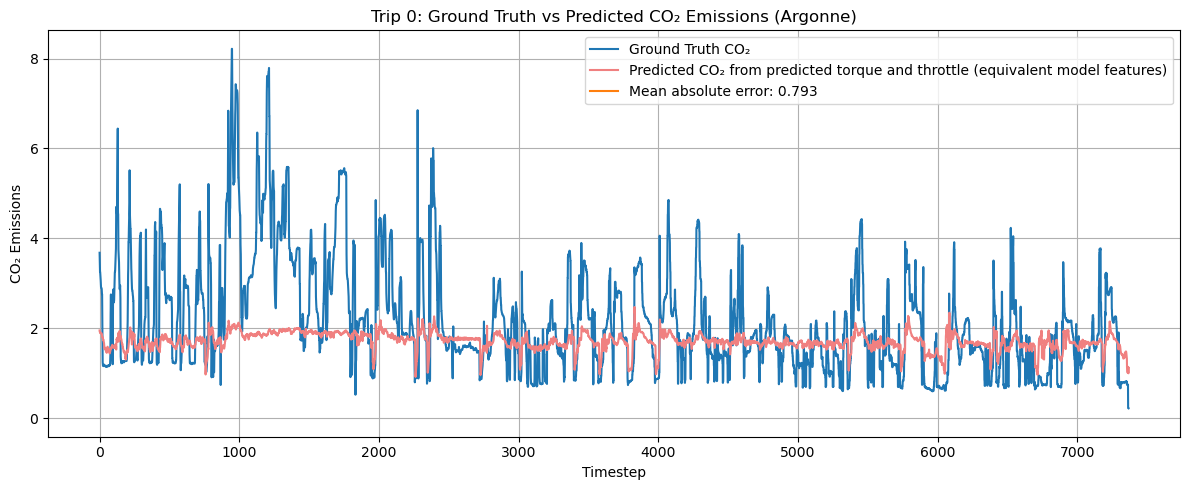

In [38]:
trip_num = 0

trip_test_x, trip_test_y = ice_x_test_1[trip_num], ice_y_test_1[trip_num] # (Vel, ambient_temp, cabin_temp, long_acceleration)

# Predict using the model
prediction_list = []
for i in range(len(trip_test_x)):
    sequence = trip_test_x[i]
    x = sequence.unsqueeze(0).to('cuda') # add batch dim
    with torch.inference_mode():
        prediction = to_th_model(x, full_sequence=True).squeeze(0).cpu()
        torque, throttle = prediction[:,0], prediction[:,1]
        # Min/Max Normalization of predictions
        torque = ((torque - trips_ice_X_scaler_2.data_min_[2])/ (trips_ice_X_scaler_2.data_max_[2] - trips_ice_X_scaler_2.data_min_[2]))
        throttle = ((throttle - trips_ice_X_scaler_2.data_min_[1])/ (trips_ice_X_scaler_2.data_max_[1] - trips_ice_X_scaler_2.data_min_[1]))
        velocity = sequence[:,0]
        x = torch.stack([velocity, throttle, torque], dim=1).unsqueeze(0).to('cuda') 
        pred = ice_model(x).squeeze(0)        
        prediction_list.append(pred)

predicted_from_equivalent = torch.stack(prediction_list).cpu()  # Predicted co2 emissions from equivalent model's throttle and torque features

trip_test_x, trip_test_y = ev_x_test_2[trip_num], ev_y_test_2[trip_num] # (Vel, ambient_temp, cabin_temp, long_acceleration)

#prediction_list = []
#for i in range(len(trip_test_x)):
#    sequence = trip_test_x[i]
#    x = sequence.unsqueeze(0).to('cuda') # add batch dim
#    with torch.inference_mode():
#        pred = ev_model(x).squeeze(0)
#        prediction_list.append(pred)

#predicted_from_original_features = torch.stack(prediction_list).cpu() 

true = trip_test_y.cpu() # match prediction window

difference_r_true = predicted_from_equivalent - true
mae_true = torch.mean(abs(difference_r_true))

#difference_r_original = predicted_from_equivalent - predicted_from_original_features
#mae_original = torch.mean(abs(difference_r_original))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(true, label='Ground Truth CO₂')
plt.plot(predicted_from_equivalent, label='Predicted CO₂ from predicted torque and throttle (equivalent model features)', color='lightcoral')
plt.plot(0, label=f'Mean absolute error: %.3f' % mae_true)

plt.xlabel('Timestep')
plt.ylabel('CO₂ Emissions')
plt.title(f'Trip {trip_num}: Ground Truth vs Predicted CO₂ Emissions (Argonne)')
plt.legend()#loc='upper right'
plt.grid(True)
plt.tight_layout()
plt.show()